<a href="https://colab.research.google.com/github/dorj222/sketch-enhancer/blob/main/gradio_sketch_enhancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Image2Image Pipeline for Stable Diffusion using Gradio**

In [13]:
!nvidia-smi

Wed Oct 18 12:06:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     8W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [14]:
!pip install -qq -U transformers ftfy gradio diffusers

In [15]:
!pip install -qq "ipywidgets>=7,<8"

In [16]:
from huggingface_hub import notebook_login

notebook_login()

In [17]:
import inspect
import warnings
from typing import List, Optional, Union

import torch
from torch import autocast
from tqdm.auto import tqdm

from diffusers import StableDiffusionImg2ImgPipeline

In [18]:
device = "cuda"
model_path = "CompVis/stable-diffusion-v1-4"

pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
  'CompVis/stable-diffusion-v1-4',
    revision="fp16",
    torch_dtype=torch.float16,
    use_auth_token=True
).to(device)
# pipe = pipe.

vae/diffusion_pytorch_model.safetensors not found


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


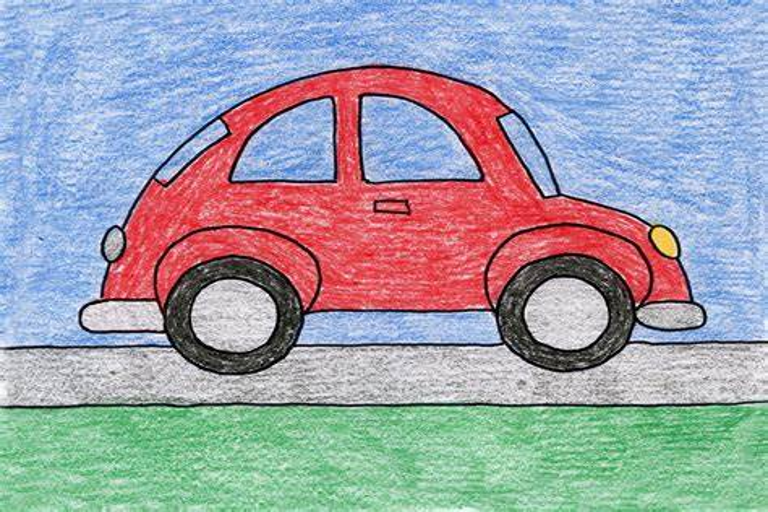

In [54]:
import requests
from io import BytesIO
from PIL import Image

url = "https://th.bing.com/th/id/OIP.ohGkZC2yTgsR4wv6GNnADAHaFu?pid=ImgDet&rs=1"

response = requests.get(url)
init_img = Image.open(BytesIO(response.content)).convert("RGB")
init_img = init_img.resize((768, 512))
init_img

In [55]:
#Define the prompt
prompt = "a offroad racing car"

In [62]:
generator = torch.Generator(device=device).manual_seed(1024)
with autocast("cuda"):
    image = pipe(prompt=prompt, image=init_img, strength=0.65, guidance_scale=7.5, generator=generator).images[0]

  0%|          | 0/32 [00:00<?, ?it/s]

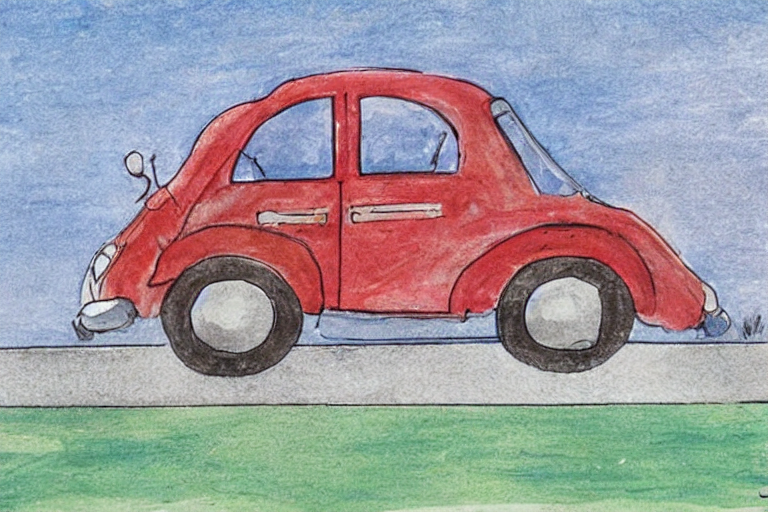

In [63]:
image

**Import Gradio library and required dependencies**

In [37]:
import gradio as gr
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from PIL import Image as PILImage

**Define a folder to save the sketches**

In [38]:
save_folder = "/content/sketches"  # Use an accessible directory in Colab
!mkdir -p $save_folder

In [39]:
def sepia(sketch):
    # Generate a unique filename
    filename = f"{save_folder}/sketch.png"

    # Save the sketch as a PNG file
    plt.imsave(filename, sketch, cmap="gray")

    # Display the saved image using IPython.display
    display(Image(filename=filename))

**Define a prompt here**

In [40]:
prompt="a white cat"

In [100]:
def save_as_pil_image(sketch):
    # Generate a unique filename
    filename = f"{save_folder}/sketch.png"
    image_data = np.array(sketch)
    extent = (0, sketch.width, 0, sketch.height)

    # Save the sketch as a PNG file
    plt.imsave(filename, image_data, cmap="viridis", origin="upper")

    # Open the saved image using PIL
    saved_image = PILImage.open(filename)

    generator = torch.Generator(device=device).manual_seed(1024)
    # return_image
    with autocast("cuda"):
        return_image = pipe(prompt=prompt, image=saved_image, strength=0.9, guidance_scale=7.5, generator=generator).images[0]

    return return_image

**Draw here the initial input sketch**

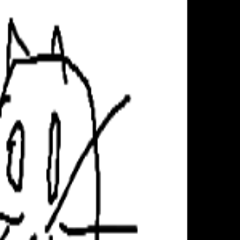

In [102]:
saved_image = PILImage.open(filename)
saved_image

In [101]:
sp =gr.Paint(label="Draw Here", brush_radius=2, type="pil", shape=(240, 240))
sepia_img = gr.Interface(fn=save_as_pil_image, inputs=sp, outputs="image", share=True).launch(debug=True);

<ipython-input-101-e910d4b7f6fc>:2: GradioUnusedKwargWarning: You have unused kwarg parameters in Interface, please remove them: {'share': True}
  sepia_img = gr.Interface(fn=save_as_pil_image, inputs=sp, outputs="image", share=True).launch(debug=True);


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://b3443e010e77480a01.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


  0%|          | 0/45 [00:00<?, ?it/s]

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/gradio/routes.py", line 534, in predict
    output = await route_utils.call_process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/route_utils.py", line 226, in call_process_api
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1550, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1185, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "/usr/local/lib/python3.10/dist-packages/anyio/to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 877, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 807, in run
    result = con

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://da84071445f4bb243d.gradio.live
Killing tunnel 127.0.0.1:7860 <> https://b3443e010e77480a01.gradio.live
